# **Libraries Installation and Import**

In [ ]:
pip install selenium selenium-wire webdriver-manager pandas scikit-learn matplotlib seaborn

In [1]:
import pandas as pd
import numpy as np
import selenium
import time
from selenium.webdriver.common.by import By
from seleniumwire import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import sklearn
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

# **Crawling**

To use selenium with google chrome we need to create a driver with the wanted url. This function will create and return a driver object.

In [ ]:
def create_driver(url):
    driver = webdriver.Chrome()
    driver.get(url)
    #print(driver.title)
    return driver

The following function takes the driver and goes through the result pages to extract the hotel names and links to their pages.
It returns a dataframe of the results.

In [ ]:
def get_hotel_links(city_driver):
    names = []
    links_for_hotel_pages = []
    distance_from_center = []
    
    number_of_pages = int(city_driver.find_element(By.CSS_SELECTOR, 'div[data-testid="pagination"]  li:last-child').text)

    for page in range(1, number_of_pages+1):
        # delete former requests
        del city_driver.requests
        # get hotel cards from search results
        hotels_from_search = city_driver.find_elements(By.CSS_SELECTOR, 'div[data-testid="property-card"]')
        # get info from each hotel card
        for hotel_card in hotels_from_search:
            names.append(hotel_card.find_element(By.CSS_SELECTOR, 'div[data-testid="title"]').text)
            links_for_hotel_pages.append(hotel_card.find_element(By.CSS_SELECTOR, 'a[data-testid="title-link"]').get_attribute('href'))
            distance_from_center.append(hotel_card.find_element(By.CSS_SELECTOR, 'span[data-testid="distance"]').text)
        # in the last page we dont need to click on next page button
        if page == number_of_pages:
            break
        # click on next page button
        next_page_btn = city_driver.find_element(By.XPATH, '//button[contains(@aria-label, "Next page")]')
        next_page_btn.click()
        # wait for the next page to load before acquiring more data or till timeout in 20 seconds
        city_driver.wait_for_request("/dml/graphql", timeout=20)
        time.sleep(5)

    hotels_info = {"hotel_names": names, "links": links_for_hotel_pages, 'distance_from_center': distance_from_center}
    city_df = pd.DataFrame(hotels_info)
    print("finished loading data")
    return city_df

This function goes through the list of cities, creates a driver and calls the function that will extract the hotel links from the browser. Then it closes the connection and saves the data into a file.

In [ ]:
def get_hotel_links_from_cities():
    cities_and_urls = {"paris": "https://www.booking.com/searchresults.en-gb.html?label=Catch_All-EN-131006968001-bPiN0WYm7x7ddzlXSroMLwS548793046706%3Apl%3Ata%3Ap1%3Ap2%3Aac%3Aap%3Aneg%3Afi%3Atiaud-294889297093%3Adsa-1642216383571%3Alp1008002%3Ali%3Adec%3Adm&sid=176ab549c47fbf99c9ee1b8552278873&aid=318615&ss=Paris&ssne=Paris&ssne_untouched=Paris&efdco=1&lang=en-gb&src=searchresults&dest_id=-1456928&dest_type=city&checkin=2023-04-10&checkout=2023-04-13&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure&nflt=ht_id%3D204",
              "nice": "https://www.booking.com/searchresults.en-gb.html?label=Catch_All-EN-131006968001-bPiN0WYm7x7ddzlXSroMLwS548793046706%3Apl%3Ata%3Ap1%3Ap2%3Aac%3Aap%3Aneg%3Afi%3Atiaud-294889297093%3Adsa-1642216383571%3Alp1008002%3Ali%3Adec%3Adm&sid=176ab549c47fbf99c9ee1b8552278873&aid=318615&ss=Nice%2C+Provence-Alpes-C%C3%B4te+d%27Azur%2C+France&ssne=Paris&ssne_untouched=Paris&lang=en-gb&src=searchresults&dest_id=-1454990&dest_type=city&ac_position=0&ac_click_type=b&ac_langcode=en&ac_suggestion_list_length=5&search_selected=true&search_pageview_id=5eb2597cf50b0023&ac_meta=GhA1ZWIyNTk3Y2Y1MGIwMDIzIAAoATICZW46BG5pY2VAAEoAUAA%3D&checkin=2023-04-10&checkout=2023-04-13&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure&nflt=ht_id%3D204",
              "marseille": "https://www.booking.com/searchresults.en-gb.html?label=Catch_All-EN-131006968001-bPiN0WYm7x7ddzlXSroMLwS548793046706%3Apl%3Ata%3Ap1%3Ap2%3Aac%3Aap%3Aneg%3Afi%3Atiaud-294889297093%3Adsa-1642216383571%3Alp1008002%3Ali%3Adec%3Adm&sid=176ab549c47fbf99c9ee1b8552278873&aid=318615&ss=Marseille%2C+Provence-Alpes-C%C3%B4te+d%27Azur%2C+France&ssne=Nice&ssne_untouched=Nice&lang=en-gb&src=searchresults&dest_id=-1449947&dest_type=city&ac_position=0&ac_click_type=b&ac_langcode=en&ac_suggestion_list_length=5&search_selected=true&search_pageview_id=00145996f939055a&ac_meta=GhAwMDE0NTk5NmY5MzkwNTVhIAAoATICZW46CW1hcnNlaWxsZUAASgBQAA%3D%3D&checkin=2023-04-10&checkout=2023-04-13&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure&nflt=ht_id%3D204",
              "lyon": "https://www.booking.com/searchresults.en-gb.html?label=Catch_All-EN-131006968001-bPiN0WYm7x7ddzlXSroMLwS548793046706%3Apl%3Ata%3Ap1%3Ap2%3Aac%3Aap%3Aneg%3Afi%3Atiaud-294889297093%3Adsa-1642216383571%3Alp1008002%3Ali%3Adec%3Adm&sid=176ab549c47fbf99c9ee1b8552278873&aid=318615&ss=Lyon%2C+Rh%C3%B4ne-Alps%2C+France&ssne=Marseille&ssne_untouched=Marseille&lang=en-gb&src=searchresults&dest_id=-1448468&dest_type=city&ac_position=0&ac_click_type=b&ac_langcode=en&ac_suggestion_list_length=1&search_selected=true&search_pageview_id=6d9459a8df7400df&ac_meta=GhA2ZDk0NTlhOGRmNzQwMGRmIAAoATICZW46CNea15jXndeeQABKAFAA&checkin=2023-04-10&checkout=2023-04-13&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure&nflt=ht_id%3D204"}
    for city in cities_and_urls.keys():
        city_driver = create_driver(cities_and_urls[city])
        city_links_df = get_hotel_links(city_driver)
        # close the driver for this hotel 
        city_driver.close()
        city_driver.quit()
        # save the information in a csv file
        file_name = "./data/" + city + "_hotel_links"
        city_links_df.to_csv(file_name, index=False)
        time.sleep(5)

Run the function that gets the hotel links from the wanted cities and saves then to csv file.

In [ ]:
get_hotel_links_from_cities()

In [ ]:
def get_parameters_from_hotels(df_links):
    list_of_parameters = {"Air conditioning": [], "Heating": [], "WiFi is available in all areas and is free of charge.": [],
                         "City view": [], "Wardrobe or closet": [], "Soundproofing": [], "TV": [], "Coffee machine": [],
                          "Private bathroom": [], "Lift": [], "Safety deposit box": [], "Pets are allowed. Charges may be applicable.": [],
                         "24-hour front desk": [], "Bar": [], "Room service": [], "Fitness centre": [], "Spa lounge/relaxation area": [],
                         "Electric kettle": [], "Minibar": [], "Tea/Coffee maker": [], "Restaurant": [], "Parking garage": [],
                          "Airport shuttle": [], "Non-smoking rooms": [], "24-hour security": [], "Towels": [],
                          "Facilities for disabled guests": [],"Hairdryer": [], "Iron": [], "Electric vehicle charging station": []}
    names = []
    stars = []
    distance = []
    pool = []
    breakfast = []
    breakfast_and_dinner = []
    addresses = []
    free_cancellations = []
    
    for ind in df_links.index:
        print("hotel number: " ,int(ind))
        # get link from df
        link = df_links.iloc[ind]['links']
        
        # create the driver for this hotel
        hotel_driver = create_driver(link)
        time.sleep(5) 
        
        try:
            # enter the main page where the first hotel is the one we want, click the first hotel name
            #hotel_page_btn = hotel_driver.find_element(By.CSS_SELECTOR, 'a[class="fc63351294 a822bdf511 d4b6b7a9e7 fa565176a8 f7db01295e f4605622ad b2f0d6a80e"]')
            hotel_page_btn = hotel_driver.find_element(By.CSS_SELECTOR, 'a[class="e13098a59f"]')
            hotel_page_btn.click()
            # wait for the hotel page to load before acquiring more data or till timeout in 20 seconds
            hotel_driver.wait_for_request("/fragment.en-gb.json", timeout=30)
            # window_after is the tab with the hotel
            window_after = hotel_driver.window_handles[1]
            # switches the current window to the new tab
            hotel_driver.switch_to.window(window_after)
            time.sleep(1)
        except Exception as e: 
            pass
            
        # add hotel name to list
        names.append(df_links['hotel_names'][ind]) 
        # get number of stars and add to list
        number_of_stars = len(hotel_driver.find_elements(By.CSS_SELECTOR, 'span[data-testid="rating-stars"]  span[class="b6dc9a9e69 adc357e4f1 fe621d6382"]'))
        stars.append(number_of_stars)
        # get distance from city center from df
        distance.append(df_links['distance_from_center'][ind])
        
        print("The current time is: ", time.ctime())
        time.sleep(15)
        print("The current time is: ", time.ctime())
        
        # from this point on we are getting parameters from the page
        # find if there are meals
        is_breakfast_and_dinner = len(hotel_driver.find_elements(By.CSS_SELECTOR, 'span[class="bui-text--color-constructive"]'))
        breakfast_and_dinner.append(1 if is_breakfast_and_dinner > 0 else 0)
        is_breakfast = len(hotel_driver.find_elements(By.CSS_SELECTOR, 'span[class="ungreen-condition-green"]'))
        breakfast.append(1 if is_breakfast > 0 else 0)
        # find if there is a pool
        titles = hotel_driver.find_elements(By.CSS_SELECTOR, 'div[class="db29ecfbe2 f0d4d6a2f5"] span[class="db312485ba"')
        is_there_pool = 0
        for title in titles:
            if title.text == "Indoor swimming pool" or title.text == "Outdoor swimming pool":
                is_there_pool = 1
        pool.append(is_there_pool)
        try:
            # wait for the address element to be present on the page
            wait = WebDriverWait(hotel_driver, 15)
            address_element = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "#showMap2 > span.hp_address_subtitle.js-hp_address_subtitle.jq_tooltip")))
            # get address
            addresses.append(address_element.text)
        except:
            # mark the address element was not present on the page
            addresses.append(None)
        # wait for the list, then get facilities from the list
        wait = WebDriverWait(hotel_driver, 40)
        facilities_list = wait.until(EC.visibility_of_all_elements_located((By.CSS_SELECTOR, 'span[class="db312485ba"')))

        # make facilities list into text
        text_facilities_list = []
        for f in facilities_list:
            text_facilities_list.append(f.text)
        # check if facilities exists
        print(df_links['hotel_names'][ind], "has" ,len(text_facilities_list), "facilities")
        # add policies- there are 2 possible classes for them in the list
        wait = WebDriverWait(hotel_driver, 25)
        try:
            policy_services = wait.until(EC.visibility_of_all_elements_located((By.CSS_SELECTOR, 'div[class="db29ecfbe2 c90c0a70d3 a34d1a4138"]')))
        except:
            try:
                policy_services = wait.until(EC.visibility_of_all_elements_located((By.CSS_SELECTOR, 'div[class="bui-spacer--medium hotel-facilities-group__policy"]')))
            except:
                print(df_links['hotel_names'][ind], "has empty policies list")

        # add the policies to the list of facilities
        for p in policy_services:
            text_facilities_list.append(p.text)
        
        # add 1 if the parameter exists
        for parameter in list_of_parameters.keys():
            if parameter in text_facilities_list:
                list_of_parameters[parameter].append(1)
            else:
                list_of_parameters[parameter].append(0)
        
        # check if there is free cancellation
        cancellations_list = hotel_driver.find_elements(By.CSS_SELECTOR, 'span[class="hprt-item--emphasised"]')
        is_there_free_cancellation = 0
        for f in cancellations_list:
            if f.text == "Free cancellation":
                is_there_free_cancellation = 1
        free_cancellations.append(is_there_free_cancellation)
        
        time.sleep(3)  
        # close the driver for this hotel 
        hotel_driver.close()
        hotel_driver.quit()
        
    # the data we got from other parts of the page(not the facilities list)
    full_data_city = {'hotel_names': names, 'star_rating': stars, 'distance_from_center': distance,
                      'swimmingpool': pool, 'breakfast': breakfast, 'breakfast_and_dinner': breakfast_and_dinner,
                      'free_cancellation': free_cancellations, 'address': addresses}
    # merge the dictioneries 
    full_data_city.update(list_of_parameters)
    return pd.DataFrame(full_data_city)

Get the links for the hotels in the city from the csv file we saved earlier.

In [ ]:
# returns dataframe with hotel names, links and distance from center
def get_links_from_file(city):
    file_name = "./data/" + city + "_hotel_links"
    df_city_links = pd.read_csv(file_name)
    return df_city_links

Go through the list of hotels and extract the wanted parameters from each hotel's page.

In [ ]:
def get_parameters_for_city(city):
    df_city_links = get_links_from_file(city)
    # get dataframe with all the parameters of the hotels
    df_parameters = get_parameters_from_hotels(df_city_links)
    # save the information in a csv file
    file_name = "./data/" + city + "_hotels_parameters"
    df_parameters.to_csv(file_name, index=False)
    time.sleep(40)
    print("finished saving parameters for {} hotels".format(city))
    print(df_parameters)
    print("----------------")
        

In [ ]:
def get_parameters_from_file(city):
    file_name = "./data/" + city + "_hotels_parameters"
    df_city_parameters = pd.read_csv(file_name)
    return df_city_parameters

Run to get the parameters from Nice.

In [ ]:
get_parameters_for_city("nice")

In [ ]:
df_nice = get_parameters_from_file("nice")
df_nice

Run to get the parameters from Marseille.

In [ ]:
get_parameters_for_city("marseille")

In [ ]:
df_marseille = get_parameters_from_file("marseille")
df_marseille

Run to get the parameters from Lyon.

In [ ]:
get_parameters_for_city("lyon")

In [ ]:
df_lyon = get_parameters_from_file("lyon")
df_lyon

Run to get the parameters from Paris.

In [ ]:
get_parameters_for_city("paris")

In [ ]:
df_paris = get_parameters_from_file("paris")
df_paris

We want to create a new dataframe which includes all the data about the hotels in all 4 cities.
First we need to add the "city" column to the hotels.
Then we need to create a new dataframe which includes all the data.

In [ ]:
df_lyon['city'] = 'Lyon'
df_nice['city'] = 'Nice'
df_marseille['city'] = 'Marseille'
df_paris['city'] = 'Paris'
# concatenate dataframes
raw_data = pd.concat([df_lyon, df_nice, df_marseille, df_paris])
# reset the indexes to run from 1 to the number of hotels
raw_data = raw_data.reset_index(drop=True)

In [ ]:
raw_data

Now let's save all the data we got as 'raw_data'.

In [ ]:
file_name = "./data/raw_data_hotels_parameters"
raw_data.to_csv(file_name, index=False)

# **Preproccessing**

Run this to get the raw data from the file:

In [2]:
file_name = "./data/raw_data_hotels_parameters"
raw_data = pd.read_csv(file_name)

In [3]:
raw_data.head()

,hotel_names,star_rating,distance_from_center,swimmingpool,breakfast,breakfast_and_dinner,free_cancellation,address,Air conditioning,Heating,...,Parking garage,Airport shuttle,Non-smoking rooms,24-hour security,Towels,Facilities for disabled guests,Hairdryer,Iron,Electric vehicle charging station,city
0,Villa Florentine,5,0.8 km from centre,1,1,0,1,"25 Montée St Barthélémy, 5th arr., 69005 Lyon,...",1,1,...,0,0,1,1,1,1,1,0,1,Lyon
1,Best Western Hotel du Pont Wilson,4,0.7 km from centre,0,1,0,1,"6, rue Mazenod, 3rd arr., 69003 Lyon, France",1,1,...,1,0,1,1,1,1,1,0,0,Lyon
2,"Hotel De Verdun 1882, BW Signature Collection",3,0.9 km from centre,0,0,0,1,"82 Rue de la Charité, 2nd arr., 69002 Lyon, Fr...",1,1,...,0,0,1,1,1,0,1,0,0,Lyon
3,Campanile Lyon Centre - Berges du Rhône,3,0.8 km from centre,0,1,0,1,"4-6, rue Mortier, 3rd arr., 69003 Lyon, France",1,1,...,1,0,1,1,1,1,1,1,1,Lyon
4,Warwick Reine Astrid - Lyon,4,2.3 km from centre,0,1,0,1,"24 Boulevard des Belges, 6th arr., 69006 Lyon,...",1,1,...,1,0,1,1,1,0,0,0,0,Lyon


We will make a copy of the raw data and then work on that.
We want to check the data types we got and how many null values we got, for that we will use the info function.

In [4]:
data_after_processing = raw_data.copy()
data_after_processing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407 entries, 0 to 1406
Data columns (total 39 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   hotel_names                                            1407 non-null   object
 1   star_rating                                            1407 non-null   int64 
 2   distance_from_center                                   1407 non-null   object
 3   swimmingpool                                           1407 non-null   int64 
 4   breakfast                                              1407 non-null   int64 
 5   breakfast_and_dinner                                   1407 non-null   int64 
 6   free_cancellation                                      1407 non-null   int64 
 7   address                                                1407 non-null   object
 8   Air conditioning                                       140

There are no null values so no need to use dropna.

Now we need to take care of the distance column. We need to make it so that the distance is a number(int) and represents the distance in meters.

In [5]:
data_after_processing.head(10)['distance_from_center']

0    0.8 km from centre
1    0.7 km from centre
2    0.9 km from centre
3    0.8 km from centre
4    2.3 km from centre
5     300 m from centre
6     400 m from centre
7    1.2 km from centre
8    3.6 km from centre
9    3.6 km from centre
Name: distance_from_center, dtype: object

The distance has a format- is says the distance is "x km from centre" or "x m from centre". We want to extract the distance and change it to be in meters.

In [6]:
import re
def get_distance_in_m(row):
    pattern = "(\d+\.?\d?) ([a-z]+)"
    match = re.search(pattern, row)
    distance = float(match.group(1))
    unit = match.group(2)
    if unit == 'km':
        distance = distance * 1000
    return int(distance)

In [7]:
data_after_processing['distance_from_center'] = data_after_processing['distance_from_center'].apply(get_distance_in_m)

In [8]:
data_after_processing.head(10)['distance_from_center']

0     800
1     700
2     900
3     800
4    2300
5     300
6     400
7    1200
8    3600
9    3600
Name: distance_from_center, dtype: int64

Now the distance from the center of the city is an integer.

In [9]:
data_after_processing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407 entries, 0 to 1406
Data columns (total 39 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   hotel_names                                            1407 non-null   object
 1   star_rating                                            1407 non-null   int64 
 2   distance_from_center                                   1407 non-null   int64 
 3   swimmingpool                                           1407 non-null   int64 
 4   breakfast                                              1407 non-null   int64 
 5   breakfast_and_dinner                                   1407 non-null   int64 
 6   free_cancellation                                      1407 non-null   int64 
 7   address                                                1407 non-null   object
 8   Air conditioning                                       140

Some hotels appear to be in the data more than once so we need to delete the duplicates and then fix the indexes.

In [10]:
data_after_processing = data_after_processing.drop_duplicates()
data_after_processing = data_after_processing.reset_index(drop=True)

In [11]:
data_after_processing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393 entries, 0 to 1392
Data columns (total 39 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   hotel_names                                            1393 non-null   object
 1   star_rating                                            1393 non-null   int64 
 2   distance_from_center                                   1393 non-null   int64 
 3   swimmingpool                                           1393 non-null   int64 
 4   breakfast                                              1393 non-null   int64 
 5   breakfast_and_dinner                                   1393 non-null   int64 
 6   free_cancellation                                      1393 non-null   int64 
 7   address                                                1393 non-null   object
 8   Air conditioning                                       139

Lets change some of the column names, for esthetic reasons.

In [12]:
data_after_processing = data_after_processing.rename(columns={'hotel_names': 'hotel_name', 
                                                              'Pets are allowed. Charges may be applicable.':'Pets',
                                                              'Air conditioning': 'air_conditioning',
                                                              'WiFi is available in all areas and is free of charge.': 'wifi',
                                                              'City view': 'view',
                                                              'Wardrobe or closet': 'closet',
                                                              'Coffee machine':'coffee_machine',
                                                              'Private bathroom': 'bathroom',
                                                              'Safety deposit box': 'safe',
                                                              '24-hour front desk': '24_hour_front_desk',
                                                              'Room service': 'room_service',
                                                              'Fitness center': 'fitness_center',
                                                              'Spa lounge/relaxation area': 'spa',
                                                              'Electric kettle': 'electric_kettle',
                                                              'Tea/Coffee maker': 'tea_coffee_maker',
                                                              'Parking garage': 'garage',
                                                              'Airport shuttle': 'airport_shuttle',
                                                              'Non-smoking rooms': 'non_smoking_rooms',
                                                              '24-hour security': 'security',
                                                              'Facilities for disabled guests': 'facilities_for_disabled_guests',
                                                              'Electric vehicle charging station': 'car_charging_station'})


We can delete the column with string values in them- hotel name and address.

In [13]:
data_after_processing.drop(columns=['hotel_name', 'address'], inplace=True)

**Outliers**

We want to check for outliers in the data.

In [14]:
data_after_processing.describe()

,star_rating,distance_from_center,swimmingpool,breakfast,breakfast_and_dinner,free_cancellation,air_conditioning,Heating,wifi,view,...,Restaurant,garage,airport_shuttle,non_smoking_rooms,security,Towels,facilities_for_disabled_guests,Hairdryer,Iron,car_charging_station
count,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,...,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000
mean,3.153625,2487.939698,0.073223,0.606604,0.020818,0.956927,0.890883,0.977746,0.864322,0.177315,...,0.188801,0.255564,0.242642,0.977746,0.646805,0.759512,0.551328,0.865757,0.284996,0.070352
std,1.140026,1558.981069,0.260596,0.488679,0.142827,0.203093,0.311898,0.147562,0.342570,0.382072,...,0.391491,0.436334,0.428834,0.147562,0.478134,0.427533,0.497537,0.341035,0.451575,0.255831
min,0.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1200.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,3.000000,2200.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
75%,4.000000,3500.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,5.000000,10900.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot: >

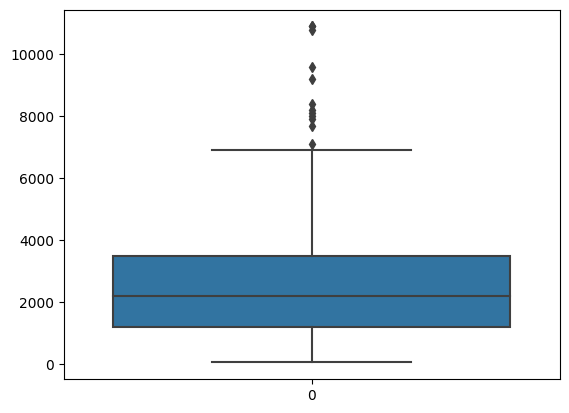

In [15]:
sns.boxplot(data_after_processing.distance_from_center)

We can see that there are outliers in the boxplot- hotels there are very far from the center of the city.

In [16]:
mycols = ["distance_from_center"]
all_outlier_rows = []
for col in mycols:        
        Q1 = np.percentile(data_after_processing[col], 25)
        Q3 = np.percentile(data_after_processing[col], 75)
        IQR = Q3 - Q1
        IQR_range = 1.5 * IQR
        col_outlier = data_after_processing[(data_after_processing[col] < Q1 - IQR_range) | 
                              (data_after_processing[col] > Q3 + IQR_range )].index
        all_outlier_rows.extend(col_outlier)
len(set(all_outlier_rows))

12

Now we can delete the outliers.

In [17]:
data_after_processing = data_after_processing.drop(index=all_outlier_rows)

Lets see how many hotels there are in each category.

In [18]:
data_after_processing['star_rating'].value_counts()

3    610
4    480
2    104
0     98
5     80
1      9
Name: star_rating, dtype: int64

We want to delete hotels with 0 stars.

In [19]:
data_after_processing = data_after_processing[data_after_processing.star_rating != 0]

Reset the indexes after deleting more rows.

In [20]:
data_after_processing = data_after_processing.reset_index(drop=True)

Now we can save the data after cleaning.

In [21]:
file_name = "./data/hotels_after_cleaning"
data_after_processing.to_csv(file_name, index=False)

# **EDA & Visualization**

We want to see what parameters affect the star rating the most. For that we can use a Heatmap.

In [22]:
file_name = "./data/hotels_after_cleaning"
final_data = pd.read_csv(file_name)

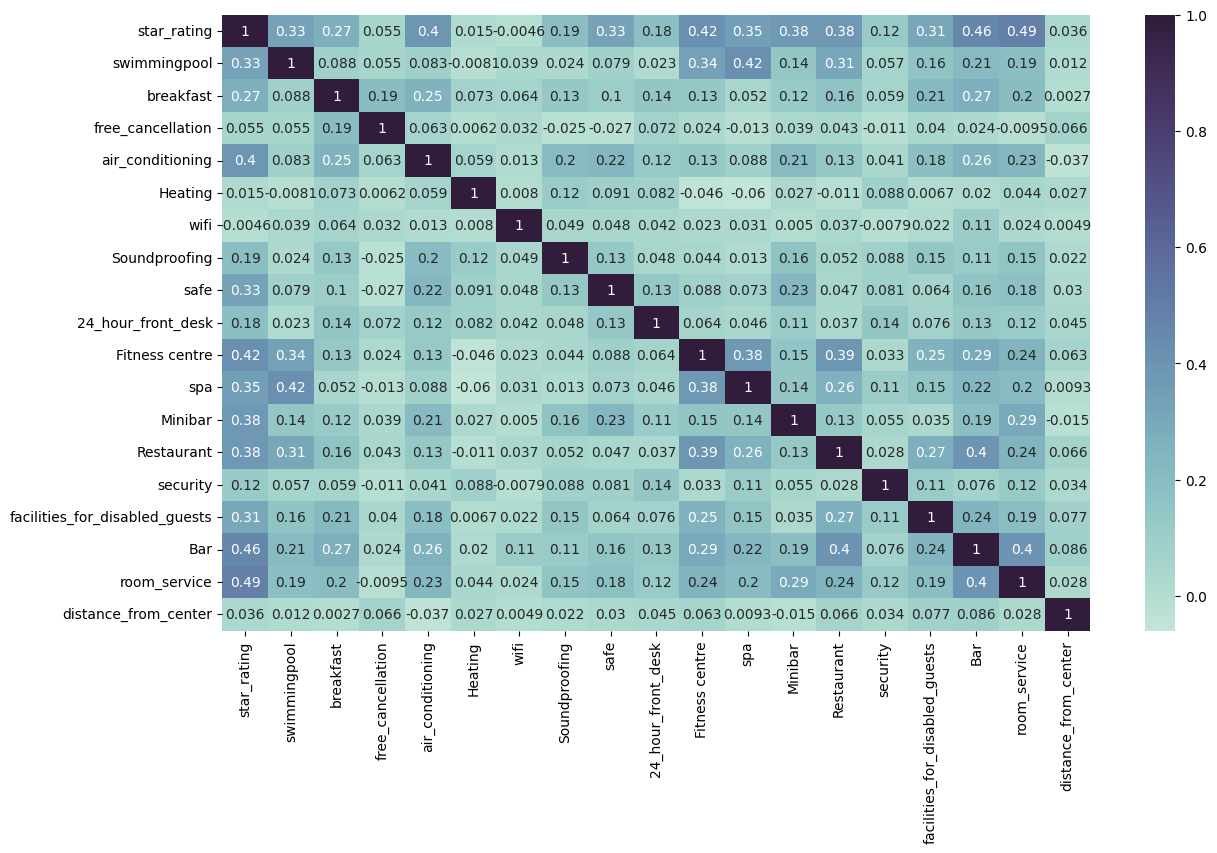

In [24]:
plt.figure(figsize=(14, 8))
cols = ['star_rating', 'swimmingpool', 'breakfast', 'free_cancellation',
       'air_conditioning', 'Heating', 'wifi', 'Soundproofing', 'safe',
       '24_hour_front_desk', 'Fitness centre',
       'spa', 'Minibar', 'Restaurant', 'security',
       'facilities_for_disabled_guests','Bar', 'room_service', 'distance_from_center']
colormap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
# make a subdataframe for the heatmap
df1 = pd.DataFrame(final_data, columns = cols)
sns.heatmap(df1.corr(), annot=True, cmap=colormap)
plt.show()

```
We can see that there are some facilities that have more influence than others, but there is no one factor that has the biggest effect on the star rating.
```

Lets add a column that sums the number of facilities and services available in the hotel.

In [25]:
cols = ['swimmingpool', 'breakfast',
       'breakfast_and_dinner', 'free_cancellation', 'air_conditioning',
       'Heating', 'wifi', 'view', 'closet', 'Soundproofing', 'TV',
       'coffee_machine', 'bathroom', 'Lift', 'safe', 'Pets',
       '24_hour_front_desk', 'Bar', 'room_service', 'Fitness centre', 'spa',
       'electric_kettle', 'Minibar', 'tea_coffee_maker', 'Restaurant',
       'garage', 'airport_shuttle', 'non_smoking_rooms', 'security', 'Towels',
       'facilities_for_disabled_guests', 'Hairdryer', 'Iron',
       'car_charging_station']
final_data['sum_facilities'] = final_data[cols].sum(axis=1)

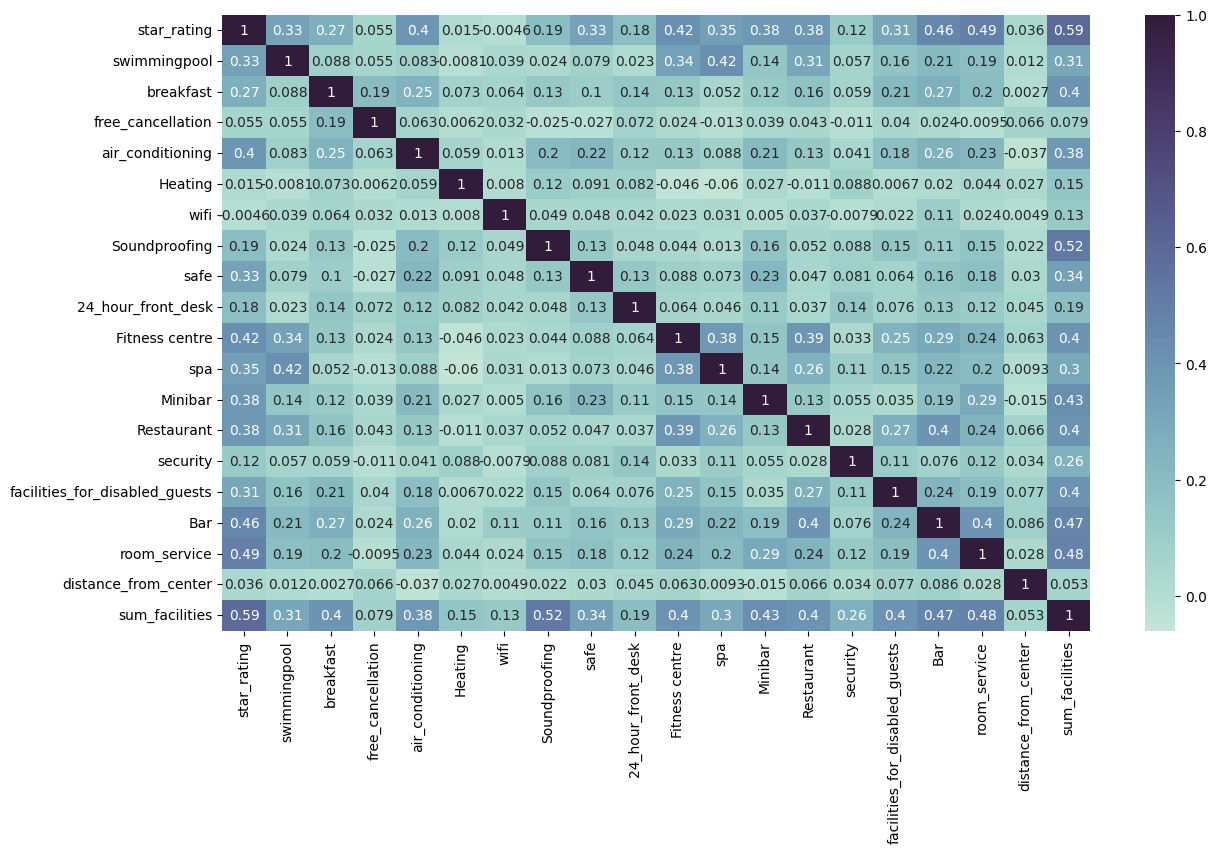

In [27]:
plt.figure(figsize=(14, 8))
cols = ['star_rating', 'swimmingpool', 'breakfast', 'free_cancellation',
       'air_conditioning', 'Heating', 'wifi', 'Soundproofing', 'safe',
       '24_hour_front_desk', 'Fitness centre',
       'spa', 'Minibar', 'Restaurant', 'security',
       'facilities_for_disabled_guests','Bar', 'room_service', 'distance_from_center', 'sum_facilities']
colormap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
# make a subdataframe for the heatmap
df1 = pd.DataFrame(final_data, columns = cols)
sns.heatmap(df1.corr(), annot=True, cmap=colormap)
plt.show()

```
We can see from the Heatmap that the 'sum_facilities' , 'room_service', 'Bar' and 'Fitness centre' parameters influence the star_rating the most.
```

<AxesSubplot: xlabel='star_rating', ylabel='sum_facilities'>

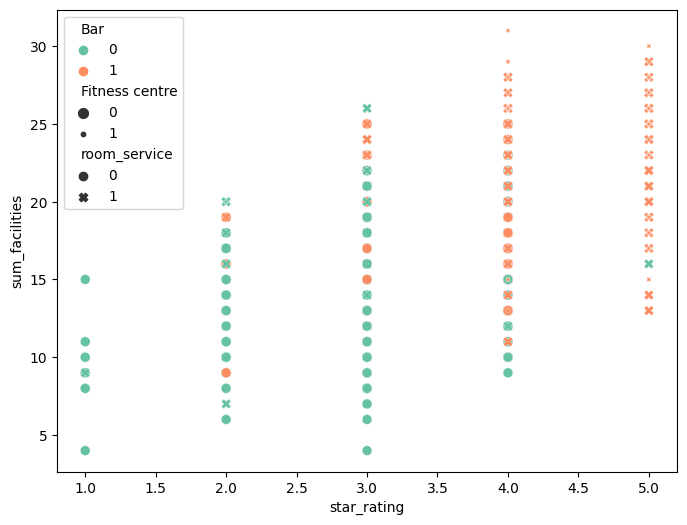

In [28]:
fig = plt.figure(figsize=(8, 6))
sns.scatterplot(x = 'star_rating', y = 'sum_facilities', size= 'Fitness centre', sizes=(10,50), 
                hue = 'Bar', style= 'room_service', data=final_data, palette=sns.color_palette("Set2", 2))

```
We can see in the scatter plot that most of the hotels with 4-5 stars have room service, bar, fitness center and a large number of facilities and services overall.
```

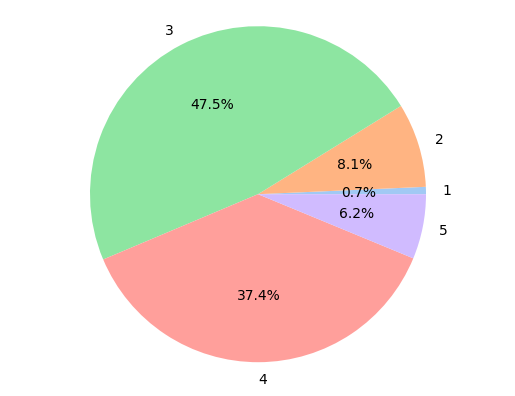

In [29]:
# group the hotels by star rating
star_ratings = data_after_processing.groupby('star_rating').size()
colormap = sns.color_palette("pastel")
plt.pie(star_ratings, labels=star_ratings.index, autopct='%1.1f%%', colors=colormap)
plt.axis('equal')
plt.show()

```
We can see that most of the hotels have either 3 or 4 stars.
```

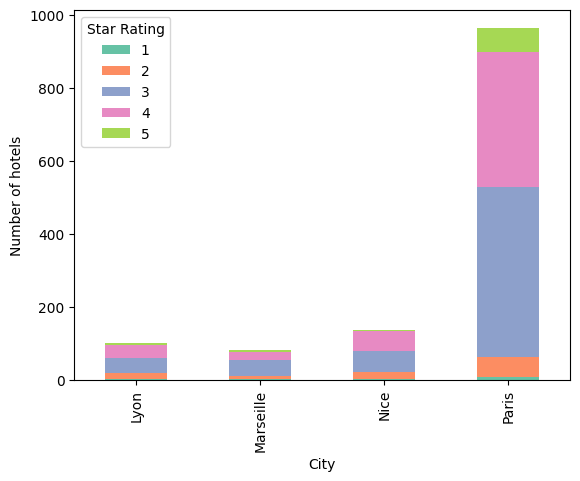

In [30]:
# Group by star rating and city and count the number of hotels in each group
grouped = final_data.groupby(['star_rating', 'city']).size().reset_index(name='hotel_count')

# Pivot the data so each row is a city and each column is a star rating
pivot = grouped.pivot(index='city', columns='star_rating', values='hotel_count')

# Plot the pivot table as a stacked bar chart using the Paired color palette from seaborn
pivot.plot(kind='bar', stacked=True, color=sns.color_palette("Set2"))

# Add a legend and labels
plt.legend(title='Star Rating')
plt.xlabel('City')
plt.ylabel('Number of hotels')

# Show the plot
plt.show()

+ Most of the hotels we got are in Paris.
+ In all of the cities we checked, most of the hotels have 3-4 stars.

# **Machine Learning**

Lets turn the 'city' column into a categorical column using a map.

In [33]:
city_map = {'Paris': 1, 'Lyon': 2, 'Marseille': 3, 'Nice': 4}
final_data['city'] = final_data['city'].map(city_map)

Our goal is to predict the star rating of a hotel. We want to classify the hotel to one of 5 groups.

The testing data should be only from the city "Paris" (where city=1).

In [40]:
# separate the data with city=1 into testing and training sets
final_data_paris = final_data[final_data['city'] == 1]
X_paris = final_data_paris.drop('star_rating', axis=1)
y_paris = final_data_paris['star_rating']
X_paris_train, X_paris_test, y_paris_train, y_paris_test = train_test_split(X_paris, y_paris, test_size=0.3)

# extract the remaining data
final_data_others = final_data[final_data['city'] != 1]
X_others = final_data_others.drop('star_rating', axis=1)
y_others = final_data_others['star_rating']

# combine the training data for city=1 and the remaining data
X_train = pd.concat([X_paris_train, X_others], axis=0)
y_train = pd.concat([y_paris_train, y_others], axis=0)

# outcome: X_train, y_train, X_paris_test, y_paris_test

**KNN**

In [51]:
# list of possible k values to try
k_list = [i for i in range(1, 31)]

# initialize arrays to store mean accuracy for each k value
accuracies = []

# loop through k values and evaluate model using cross-validation
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn, X_train, y_train, cv=5)
    mean_accuracy = np.mean(cv_scores)
    accuracies.append(mean_accuracy)

# find the k value with the highest mean accuracy
best_k = k_list[accuracies.index(max(accuracies))]

# initialize and fit KNN model with the best k value
knn = KNeighborsClassifier(n_neighbors=best_k)
# train the model
knn.fit(X_train, y_train)

# predict the star_value for the testing data
y_pred = knn.predict(X_paris_test)

# evaluate model on testing set for city=1
print("Accuracy on test data:", knn.score(X_paris_test, y_paris_test) ,"Best K:", best_k)
# 'weighted': This computes the weighted average F1-Score of all classes, taking into account the number of samples in each class
print('f1 is:',metrics.f1_score(y_paris_test, y_pred, average='weighted'))


Accuracy on test data: 0.5448275862068965 Best K: 7
f1 is: 0.5056975004561212


**Naive Bayes**

In [42]:
# Train a Gaussian Naive Bayes model
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Predict on the training and testing sets
y_train_pred = gnb.predict(X_train)
y_test_pred = gnb.predict(X_paris_test)

# Calculate the accuracy on the training and testing sets
train_accuracy = metrics.accuracy_score(y_train, y_train_pred)
test_accuracy = metrics.accuracy_score(y_paris_test, y_test_pred)

print("Accuracy on training data:", train_accuracy)
print("Accuracy on test data:", test_accuracy)
# 'weighted': This computes the weighted average F1-Score of all classes, taking into account the number of samples in each class
print('f1 is:',metrics.f1_score(y_paris_test, y_test_pred, average='weighted'))

Accuracy on training data: 0.5468277945619335
Accuracy on test data: 0.5379310344827586
f1 is: 0.5785805250199463


**Decision Tree**

In [43]:
# Define the parameter grid
param_grid = {'max_depth': [1, 5, 10, 15, 20, 25, 30, None],
              'min_samples_split': [2, 4, 6, 8, 10]}

decisionTree = tree.DecisionTreeClassifier()

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=decisionTree, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters found
print('Best max_depth:', grid_search.best_params_['max_depth'])
print('Best min_samples_split:', grid_search.best_params_['min_samples_split'])

# Re-fit the decision tree with the best parameters
best_decisionTree = grid_search.best_estimator_
best_decisionTree.fit(X_train, y_train)
# Predict and evaluate accuracy on training data
y_pred_train = best_decisionTree.predict(X_train)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_train))

# Predict and evaluate accuracy on testing data
y_pred = best_decisionTree.predict(X_paris_test)
print('Accuracy on test data = ', metrics.accuracy_score(y_true = y_paris_test, y_pred = y_pred))
# 'weighted': This computes the weighted average F1-Score of all classes, taking into account the number of samples in each class
print('f1 is:',metrics.f1_score(y_paris_test, y_pred, average='weighted'))

Best max_depth: 5
Best min_samples_split: 4
Accuracy on training data=  0.7311178247734139
Accuracy on test data =  0.7344827586206897
f1 is: 0.7319387779482374


**Random Forest**

In [44]:
forest =  RandomForestClassifier(bootstrap=True, n_estimators=120, random_state=0,
                                  min_samples_split=10, min_samples_leaf=5, max_depth=15)

trained_forest = forest.fit(X_train, y_train) 

# Predict and evaluate accuracy on training data
y_pred_train = trained_forest.predict(X_train)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_train))

# Predict and evaluate accuracy on testing data
y_pred = trained_forest.predict(X_paris_test)

print('Accuracy on test data= ', metrics.accuracy_score(y_true = y_paris_test, y_pred = y_pred))
# 'weighted': This computes the weighted average F1-Score of all classes, taking into account the number of samples in each class
print('f1 is:',metrics.f1_score(y_paris_test, y_pred, average='weighted'))

Accuracy on training data=  0.7794561933534743
Accuracy on test data=  0.7241379310344828
f1 is: 0.7042293798155868


```
When predicting the star rating of a hotel, the KNN and Naive Bayes models have the least accurate scores whilst the Random Forest and Decision Tree algorithms give the most accurate results.
```

**Logistic Regression**

Now we want to predict if a hotel is 'good' or 'bad'. We define a hotel with 4 or 5 stars as 'good'. First we'll add a column that has 1- if the hotel is 'good' and 0 otherwise. 

In [45]:
df_for_good_or_bad = final_data.copy()
df_for_good_or_bad['is_hotel_good'] = np.where(df_for_good_or_bad['star_rating'] >= 4, 1, 0)

del df_for_good_or_bad['star_rating']

In [46]:
df_for_good_or_bad.head(10)

,distance_from_center,swimmingpool,breakfast,breakfast_and_dinner,free_cancellation,air_conditioning,Heating,wifi,view,closet,...,non_smoking_rooms,security,Towels,facilities_for_disabled_guests,Hairdryer,Iron,car_charging_station,city,sum_facilities,is_hotel_good
0,800,1,1,0,1,1,1,1,0,0,...,1,1,1,1,1,0,1,2,27,1
1,700,0,1,0,1,1,1,1,0,1,...,1,1,1,1,1,0,0,2,22,1
2,900,0,0,0,1,1,1,1,0,1,...,1,1,1,0,1,0,0,2,18,0
3,800,0,1,0,1,1,1,1,0,1,...,1,1,1,1,1,1,1,2,22,0
4,2300,0,1,0,1,1,1,0,1,1,...,1,1,1,0,0,0,0,2,24,1
5,300,0,1,0,1,1,1,1,1,0,...,1,1,1,0,1,1,0,2,20,0
6,400,0,1,0,1,1,1,0,0,1,...,1,1,1,1,1,1,0,2,27,1
7,1200,0,0,0,1,1,1,1,0,1,...,1,1,1,0,1,1,0,2,14,0
8,3600,0,1,0,1,1,1,1,0,0,...,1,1,0,1,1,0,1,2,22,1
9,250,0,0,0,1,1,1,1,1,1,...,1,1,1,0,1,0,0,2,18,0


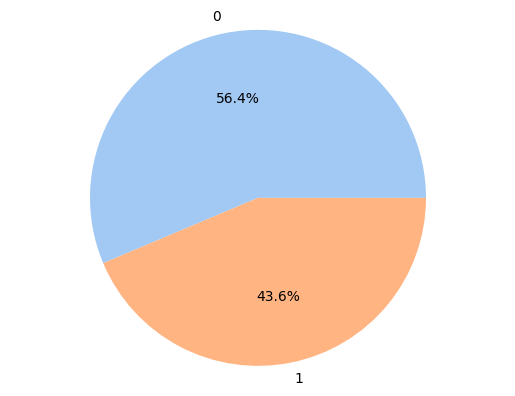

In [47]:
good_hotels = df_for_good_or_bad.groupby('is_hotel_good').size()
colormap = sns.color_palette("pastel")
plt.pie(good_hotels, labels=good_hotels.index, autopct='%1.1f%%', colors=colormap)
plt.axis('equal')
plt.show()

In [48]:
# separate the data with city=1 into testing and training sets
final_data_paris2 = df_for_good_or_bad[df_for_good_or_bad['city'] == 1]
X_paris2 = final_data_paris2.drop('is_hotel_good', axis=1)
y_paris2 = final_data_paris2['is_hotel_good']
X_paris_train2, X_paris_test2, y_paris_train2, y_paris_test2 = train_test_split(X_paris2, y_paris2, test_size=0.3)

# extract the remaining data
final_data_others2 = df_for_good_or_bad[df_for_good_or_bad['city'] != 1]
X_others2 = final_data_others2.drop('is_hotel_good', axis=1)
y_others2 = final_data_others2['is_hotel_good']

# combine the training data for city=1 and the remaining data
X_train2 = pd.concat([X_paris_train2, X_others2], axis=0)
y_train2 = pd.concat([y_paris_train2, y_others2], axis=0)

In [49]:
# Train a logistic regression l_r_model
l_r_model = LogisticRegression(max_iter=1000)
l_r_model.fit(X_train2, y_train2)

# Predict the target on the test set
y_pred2 = l_r_model.predict(X_paris_test2)

# Check the accuracy of the l_r_model
print("Accuracy:", metrics.accuracy_score(y_paris_test2, y_pred2))
print("Precision:",metrics.precision_score(y_paris_test2, y_pred2))
print("Recall:",metrics.recall_score(y_paris_test2, y_pred2))
print("F1:",metrics.f1_score(y_paris_test2, y_pred2))

Accuracy: 0.8586206896551725
Precision: 0.7923076923076923
Recall: 0.8803418803418803
F1: 0.8340080971659919


```
When predicting if a hotel is 'good' the Logistic Regression model has approximately 85% accuracy.
```

# **Summary**

+ Most of the hotels have 3 or 4 stars.

+ The star rating has the highest correlation with sum facilities.

+ The most accurate models for star rating prediction are Decision Tree and Random Forest with approximately 70% accuracy.

+ 43.6% of the hotels are considered to be 'good'(4-5 stars).

+ Most of the 'good' hotels have room service, bar, fitness center and a large number of facilities and services overall.

+ We can predict wether a hotel is 'good' or not with approximately 85% accuracy.

# **Credits**

https://www.scrapingbee.com/blog/web-scraping-booking/
https://selenium-python.readthedocs.io/locating-elements.html
https://stackoverflow.com/questions/72165030/selenium-script-searches-previous-tabs-html-after-opening-a-new-tab
https://stackoverflow.com/questions/66956197/vs-code-modulenotfounderror-no-module-named-sklearn